# 準備

In [1]:
from PIL import Image
from io import BytesIO 
import os
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
path = "./image"
flist = os.listdir(path)

In [3]:
!ls -a "./image"

.            cat_004.xml  cat_009.jpg  dog_001.xml  dog_006.jpg  dog_010.xml
..           cat_005.jpg  cat_009.xml  dog_002.jpg  dog_006.xml  dog_012.jpeg
cat_001.jpg  cat_005.xml  cat_010.jpg  dog_002.xml  dog_007.jpg  dog_012.xml
cat_001.xml  cat_006.jpg  cat_010.xml  dog_003.jpg  dog_007.xml  dog_11.jpg
cat_002.jpg  cat_006.xml  cat_011.jpeg dog_003.xml  dog_008.jpg  dog_11.xml
cat_002.xml  cat_007.jpg  cat_011.xml  dog_004.jpg  dog_008.xml
cat_003.jpg  cat_007.xml  cat_012.jpg  dog_004.xml  dog_009.jpg
cat_003.xml  cat_008.jpg  cat_012.xml  dog_005.jpg  dog_009.xml
cat_004.jpg  cat_008.xml  dog_001.jpg  dog_005.xml  dog_010.jpg


In [161]:
img_list = []
for img in flist:
    img_list.append(path+ "/" + img)

In [162]:
img_list

['./image/dog_11.jpg',
 './image/dog_009.jpg',
 './image/cat_009.jpg',
 './image/cat_008.jpg',
 './image/dog_008.jpg',
 './image/dog_012.jpeg',
 './image/cat_011.jpeg',
 './image/dog_006.jpg',
 './image/cat_012.jpg',
 './image/cat_006.jpg',
 './image/cat_007.jpg',
 './image/dog_007.jpg',
 './image/dog_005.jpg',
 './image/cat_005.jpg',
 './image/cat_010.jpg',
 './image/cat_004.jpg',
 './image/dog_010.jpg',
 './image/dog_004.jpg',
 './image/cat_001.jpg',
 './image/dog_001.jpg',
 './image/dog_003.jpg',
 './image/cat_003.jpg',
 './image/cat_002.jpg',
 './image/dog_002.jpg']

In [163]:
dog_img_array = np.empty([0, 224, 224, 3])
cat_img_array = np.empty([0, 224, 224, 3])

for img in img_list:
    if re.search("dog", img):
        dog_img_ = Image.open(img)
        dog_img_ = dog_img_.resize((224, 224))
        dog_img = np.array(dog_img_) / 255.
        dog_img = dog_img.reshape((1, 224, 224, 3))
        dog_img_array = np.concatenate((dog_img_array, dog_img), axis=0)
    if re.search("cat", img):
        cat_img_ = Image.open(img)
        cat_img_ = cat_img_.resize((224, 224))
        cat_img = np.array(cat_img_) / 255.
        cat_img = cat_img.reshape((1, 224, 224, 3))
        cat_img_array = np.concatenate((cat_img_array, cat_img), axis=0)

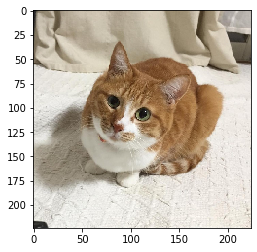

In [164]:
plt.imshow(cat_img_array[0])

plt.show()

# 【問題1】自作データセットでの分類の学習
自作のデータセットに対して分類問題を解いてください。任意の実装を使用してください。

In [140]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [234]:
def conv(filters, kernel_size, strides=1):
    return Conv2D(filters, kernel_size, strides, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(10))

In [235]:
def resnet_unitA(filters, strides=1):
    def f(x):
        x = BatchNormalization()(x)
        b = Activation("relu")(x)

        x = conv(filters//4, 1, strides)(b)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = conv(filters//4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = conv(filters, 1)(x)

        sc = conv(filters, 1, strides)(b)

        x = Add()([x, sc])

        return x
    return f

In [236]:
def resnet_unitB(filters):
    def f(x):
        sc = x

        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = conv(filters//4, 1)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = conv(filters//4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = conv(filters, 1)(x)

        x = Add()([x, sc])

        return x
    return f

In [237]:
def resnet_block(filters, strides, unit_size):
    def f(x):
        x = resnet_unitA(filters, strides)(x)
        for i in range(unit_size-1):
            x = resnet_unitB(filters)(x)
        return x
    return f

In [238]:
input = Input(shape=(224, 224, 3))

x = conv(16, 3)(input)

x = resnet_block(64, 1, 18)(x)
x = resnet_block(128, 2, 18)(x)
x = resnet_block(256, 2, 18)(x)

x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D()(x)
x = Flatten()(x)

x = Dense(256)(x)
x = Activation("relu")(x)
x = Dense(2)(x)
output = Activation("softmax")(x)

model = Model(inputs = input, outputs = output)

In [241]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001, momentum=0.9), metrics=['acc'])

In [144]:
data = np.concatenate((dog_img_array, cat_img_array), axis =0)

In [145]:
tr_x = np.concatenate((dog_img_array[0:11], cat_img_array[0:11]), axis =0)
val_x = data[[0,21]]

In [146]:
tr_y = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tr_y = tr_y.reshape([22, 1])
val_y = np.array([1, 0])
val_y = val_y.reshape([2, 1])

In [147]:
tr_y = to_categorical(tr_y)
val_y = to_categorical(val_y)

In [229]:
print(tr_y)
print(val_y)
print(tr_x.shape)
print(val_x.shape)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [1. 0.]]
(22, 224, 224, 3)
(2, 224, 224, 3)


In [230]:
val_x.shape

(2, 224, 224, 3)

In [242]:
history = model.fit(tr_x, tr_y, epochs=10, validation_data=(val_x, val_y), )

Train on 22 samples, validate on 2 samples
Epoch 1/10
22/22 [==============================] - 150s 7s/sample - loss: 248890.8750 - acc: 0.6818 - val_loss: 241041.3125 - val_acc: 0.5000
Epoch 2/10
22/22 [==============================] - 125s 6s/sample - loss: 239048.0781 - acc: 0.5000 - val_loss: 272026.2188 - val_acc: 0.5000
Epoch 3/10
22/22 [==============================] - 118s 5s/sample - loss: 221137.9375 - acc: 0.5000 - val_loss: 208646.2031 - val_acc: 0.5000
Epoch 4/10
22/22 [==============================] - 117s 5s/sample - loss: 197221.9375 - acc: 0.5000 - val_loss: 169865.9688 - val_acc: 0.5000
Epoch 5/10
22/22 [==============================] - 117s 5s/sample - loss: 169579.4219 - acc: 0.5909 - val_loss: 140383.6562 - val_acc: 0.5000
Epoch 6/10
22/22 [==============================] - 116s 5s/sample - loss: 140366.9062 - acc: 0.5455 - val_loss: 111483.3047 - val_acc: 0.5000
Epoch 7/10
22/22 [==============================] - 116s 5s/sample - loss: 111482.7656 - acc: 0.590

正解率は上がってないがロスは減っているから学習はできている？流石に２２個、１０エポックでは学習できてない。

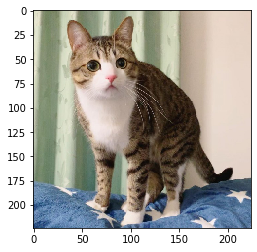

In [108]:
plt.imshow(val_x[1])
plt.show()

# 【問題2】分類データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。

In [209]:
dog_img_aug = dog_img_array
cat_img_aug = cat_img_array

## 中心を切り取る

In [210]:
def crop_center(pil_img, crop_width, crop_height):
    
    img_width, img_height = pil_img.size
    
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [211]:
for img in img_list:
    if re.search("dog", img):
        dog_img_ = Image.open(img)
        dog_img_ = crop_center(dog_img_, 224, 224)
        dog_img = np.array(dog_img_) / 255.
        dog_img = dog_img.reshape((1, 224, 224, 3))
        dog_img_aug = np.concatenate((dog_img_aug, dog_img), axis=0)
    if re.search("cat", img):
        cat_img_ = Image.open(img)
        cat_img_ = crop_center(cat_img_, 224, 224)
        cat_img = np.array(cat_img_) / 255.
        cat_img = cat_img.reshape((1, 224, 224, 3))
        cat_img_aug = np.concatenate((cat_img_aug, cat_img), axis=0)

In [213]:
dog_img_aug.shape

(24, 224, 224, 3)

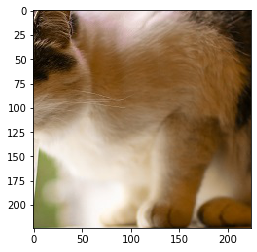

In [212]:
plt.imshow(cat_img_aug[22])
plt.show()

## 反転させる

In [214]:
import albumentations as alb

In [12]:
def get_augmentation():
    train_transform = [
        alb.HorizontalFlip(p=1),
        alb.VerticalFlip(p=1),
    ]
    return alb.Compose(train_transform)

In [216]:
transform = get_augmentation()
for dog_img in dog_img_aug:
    augmented = transform(image=dog_img)
    augmented = augmented['image']
    dog_augmented = augmented.reshape((1, 224, 224, 3))
    dog_img_aug = np.concatenate((dog_img_aug, dog_augmented), axis=0)

for cat_img in cat_img_aug:
    augmented = transform(image=cat_img)
    augmented = augmented['image']
    cat_augmented = augmented.reshape((1, 224, 224, 3))
    cat_img_aug = np.concatenate((cat_img_aug, cat_augmented), axis=0)

In [217]:
dog_img_aug.shape

(48, 224, 224, 3)

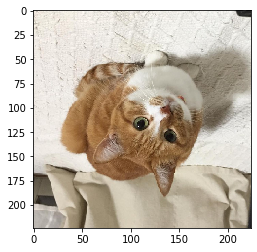

In [218]:
plt.imshow(cat_img_aug[24])
plt.show()

# 【問題3】物体検出データセットの用意
次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。

In [220]:
!git clone https://github.com/tzutalin/labelImg.git

Cloning into 'labelImg'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1563 (delta 0), reused 0 (delta 0), pack-reused 1562
Receiving objects: 100% (1563/1563), 232.62 MiB | 8.53 MiB/s, done.
Resolving deltas: 100% (925/925), done.


In [221]:
cd labelImg

/Users/niikurasayaka/diveintocode-ml/Sprint17/labelImg


In [225]:
!make qt5py3

pyrcc5 -o libs/resources.py resources.qrc


In [226]:
!python3 labelImg.py

Image:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_001.jpg -> Annotation:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_001.xml
Image:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_002.jpg -> Annotation:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_002.xml
Image:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_003.jpg -> Annotation:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_003.xml
Image:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_004.jpg -> Annotation:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_004.xml
Image:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_005.jpg -> Annotation:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_005.xml
Image:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_006.jpg -> Annotation:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_006.xml
Image:/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_007.jpg -> Annotation:/Users/niikurasayaka/diveint

# 【問題4】物体検出データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。前述のalbumentationsはバウンディングボックスを合わせての加工が可能です。詳細はREADME.mdを確認してください。

In [9]:
%matplotlib inline
from urllib.request import urlopen
import os

from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [10]:
import albumentations as alb

In [22]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='pascal_voc', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

In [14]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    # x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    

In [27]:
image = Image.open("/Users/niikurasayaka/diveintocode-ml/Sprint17/image/cat_009.jpg")
image = np.array(image)

In [28]:
annotations = {'image': image, 'bboxes': [[136, 91, 560, 527]], 'category_id': [0]}
category_id_to_name = {0: 'cat', 1: 'dog'}

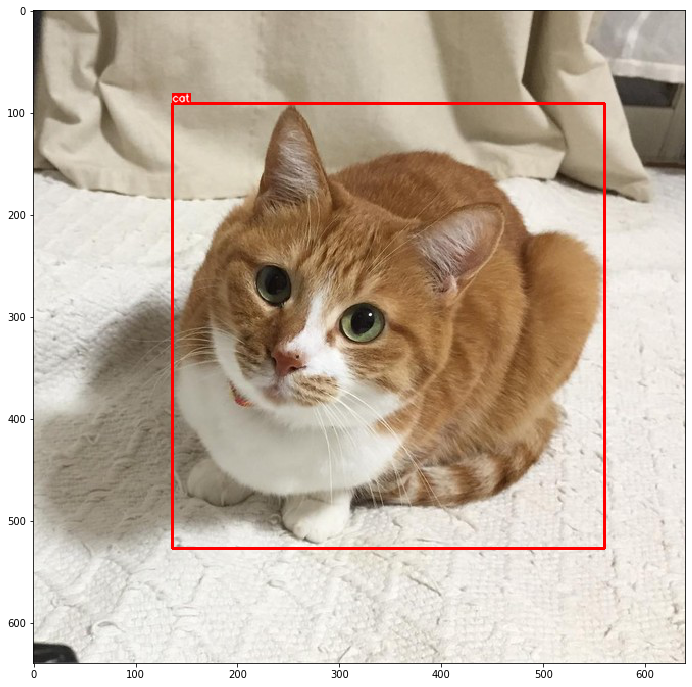

In [29]:
visualize(annotations, category_id_to_name)

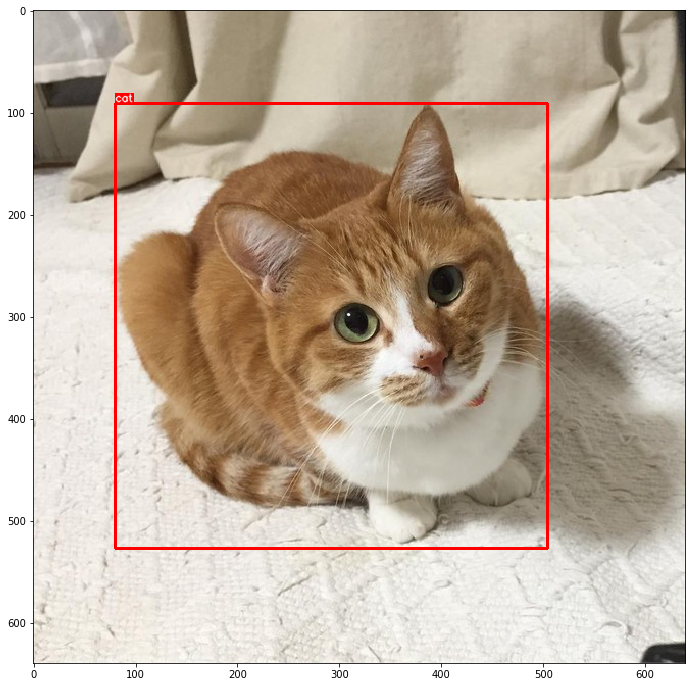

In [30]:
aug = get_aug([HorizontalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

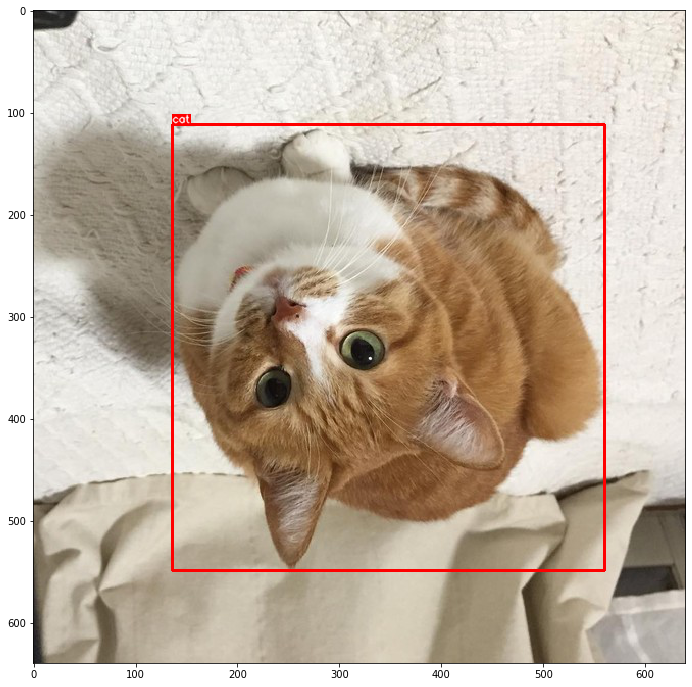

In [31]:
aug = get_aug([VerticalFlip(p=1)])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)